<a href="https://colab.research.google.com/github/reshalfahsi/image-classification-vit/blob/master/Image_Classification_With_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification With Vision Transformer**

## **Important Libraries**

### **Install**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 43.0 MB/s eta 0:00:00


### **Import**

In [ ]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.classification import Accuracy

from google.colab.patches import cv2_imshow

from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data.dataloader import default_collate

from torchvision.ops import MLP, Conv2dNormActivation
from torchvision.transforms import (
    Compose,
    RandAugment,
    ToTensor,
    Resize,
    Lambda
)
from torchvision.transforms.v2 import CutMix, MixUp, RandomChoice
from torchvision.datasets import CIFAR100

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import math
import copy
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [ ]:
IMAGE_SIZE        = 80
PATCH_SIZE        = 8
NUM_LAYERS        = 5
NUM_HEADS         = 12
HIDDEN_DIM        = 96
MLP_DIM           = int(2.5 * HIDDEN_DIM)
DROPOUT           = 0.42
ATTENTION_DROPOUT = 0.07
NUM_CLASSES       = 100
MLP_CLASSIFIER    = [4800, 1200]

In [ ]:
EPOCH      = 10 ** 2
BATCH_SIZE = 16 ** 2

In [ ]:
EARLY_STOPPING_PATIENCE = 1. / math.pi

In [ ]:
LEARNING_RATE = 6.9e-4
WEIGHT_DECAY  = 6.9e-2

In [ ]:
BASE_LR_SCALE = 1e-3

In [ ]:
METRIC_TO_MONITOR = "val_acc"
METRIC_MODE       = "max"

In [ ]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 731364399


## **Dataset**

### **Utils**

In [ ]:
TRAIN_TRANSFORM = Compose(
    [
        RandAugment(),
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)
TEST_TRANSFORM = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

In [ ]:
def COLLATE_FUNCTION(batch):
    return RandomChoice(
        [
            CutMix(num_classes=NUM_CLASSES),
            MixUp(num_classes=NUM_CLASSES),
        ]
    )(*default_collate(batch))

### **Load**

In [ ]:
TrainDataset = CIFAR100(
    root="experiment/dataset",
    train=True,
    transform=TRAIN_TRANSFORM,
    download=True,
)
ValDataset = CIFAR100(
    root="experiment/dataset",
    train=False,
    transform=TEST_TRANSFORM,
    download=True,
)
TestDataset = CIFAR100(
    root="experiment/dataset",
    train=False,
    transform=TEST_TRANSFORM,
    download=True,
)

100%|██████████| 169001437/169001437 [00:03<00:00, 49003336.30it/s]


Extracting experiment/dataset/cifar-100-python.tar.gz to experiment/dataset
Files already downloaded and verified
Files already downloaded and verified


### **Data Distribution**

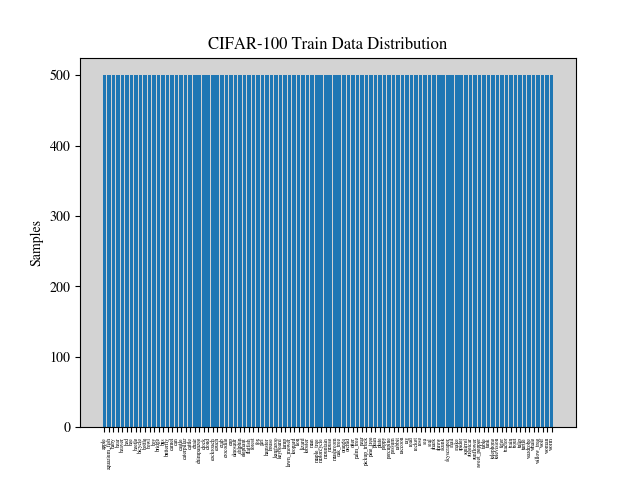

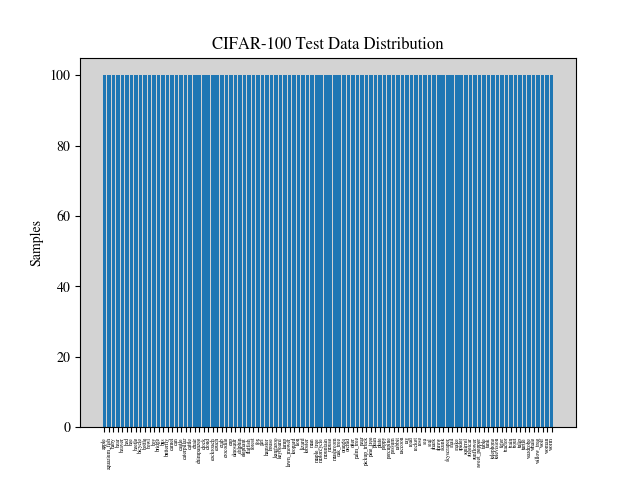

<Figure size 640x480 with 0 Axes>

In [ ]:
def visualize_distribution(cifar100_dataset):
    split = "train" if cifar100_dataset.train else "test"

    num_samples = len(cifar100_dataset.classes) * [0]

    for idx in range(len(cifar100_dataset)):
        _, cls = cifar100_dataset[idx]
        num_samples[int(cls)] += 1

    # Create bar plot
    plt.bar(cifar100_dataset.classes, num_samples)

    # Customize labels and title
    plt.ylabel('Samples')
    plt.title(f'CIFAR-100 {split.title()} Data Distribution')

    plt.xticks(fontsize=4, rotation=90)

    img_path = f"experiment/dataset/{split}_data_distribution.png"

    plt.savefig(img_path)
    plt.clf()
    img = cv2.imread(img_path)
    cv2_imshow(img)


visualize_distribution(TrainDataset)
visualize_distribution(TestDataset)

## **Model**

### **Utils**

In [ ]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Vision Transformer**

In [ ]:
class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = nn.LayerNorm(hidden_dim, eps=1e-6)
        self.self_attention = nn.MultiheadAttention(
            hidden_dim,
            num_heads,
            dropout=attention_dropout,
            batch_first=True,
        )
        self.dropout = dropout

        # MLP block
        self.ln_2 = nn.LayerNorm(hidden_dim, eps=1e-6)
        self.mlp = MLP(
            hidden_dim,
            [mlp_dim, hidden_dim],
            activation_layer=nn.GELU,
            dropout=dropout,
        )

    def forward(self, input: torch.Tensor):
        torch._assert(
            input.dim() == 3,
            f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}",
        )
        x = self.ln_1(input)
        x, self.saved_attention = self.self_attention(
            x, x, x, need_weights=True
        )
        x = F.dropout(x, self.dropout, self.training)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y

In [ ]:
class Encoder(nn.Module):
    """Transformer Model Encoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
    ):
        super().__init__()
        # Note that batch_size is on the first dim because
        # we have batch_first=True in nn.MultiAttention() by default
        self.pos_embedding = nn.Parameter(
            torch.empty(1, seq_length, hidden_dim).normal_(std=0.02)
        )  # from BERT
        self.dropout = dropout
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = EncoderBlock(
                num_heads,
                hidden_dim,
                mlp_dim,
                dropout,
                attention_dropout,
            )
        self.layers = nn.Sequential(layers)
        self.ln = nn.LayerNorm(hidden_dim, eps=1e-6)

    def forward(self, input: torch.Tensor):
        torch._assert(
            input.dim() == 3,
            f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}",
        )
        input = input + self.pos_embedding
        return F.dropout(
            self.ln(
                self.layers(input)
            ),
            self.dropout,
            self.training,
        )

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size: int = IMAGE_SIZE,
        patch_size: int = PATCH_SIZE,
        num_layers: int = NUM_LAYERS,
        num_heads: int = NUM_HEADS,
        hidden_dim: int = HIDDEN_DIM,
        mlp_dim: int = MLP_DIM,
        dropout: float = DROPOUT,
        attention_dropout: float = ATTENTION_DROPOUT,
        mlp_classifier = MLP_CLASSIFIER,
        num_classes: int = NUM_CLASSES,
        stride_conv: int = 2,
        kernel_conv: int = 3,
    ):
        super().__init__()

        #  Embedding
        # As per https://arxiv.org/abs/2106.14881
        self.conv_proj = nn.Sequential()
        prev_channels = 3
        norm_layer = nn.BatchNorm2d
        activation_layer = nn.ReLU
        n_conv_layer = int(math.log(patch_size) / math.log(stride_conv))
        conv_scale = 1
        for idx in range(n_conv_layer):
            if idx == n_conv_layer - 1:
                activation_layer = None
                conv_scale = 1
            self.conv_proj.add_module(
                f"conv_bn_relu_{idx}",
                Conv2dNormActivation(
                    in_channels=prev_channels,
                    out_channels=int(hidden_dim * conv_scale),
                    kernel_size=kernel_conv,
                    stride=stride_conv,
                    norm_layer=norm_layer,
                    activation_layer=activation_layer,
                ),
            )
            prev_channels = int(hidden_dim * conv_scale)
            conv_scale += 0.5

        seq_length = ((image_size // patch_size) ** 2)
        self.patch_num = seq_length

        self.encoder = Encoder(
            seq_length,
            num_layers,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
        )

        self.mlp_classifier = MLP(
            hidden_dim
            * self.patch_num,
            mlp_classifier,
            activation_layer=nn.GELU,
            dropout=dropout,
        )
        self.classifier = nn.Linear(mlp_classifier[-1], num_classes)

        self.image_size = image_size
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim

    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.patch_size
        torch._assert(
            h == self.image_size,
            f"Wrong image height! Expected {self.image_size} but got {h}!",
        )
        torch._assert(
            w == self.image_size,
            f"Wrong image width! Expected {self.image_size} but got {w}!",
        )

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = self.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.hidden_dim, self.patch_num)

        # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
        # The self attention layer expects inputs in the format (N, S, E)
        # where S is the source sequence length, N is the batch size, E is the
        # embedding dimension
        x = x.permute(0, 2, 1)

        return x

    def forward(self, x: torch.Tensor):
        # Reshape and permute the input tensor
        x = self._process_input(x)

        x = self.encoder(x)

        x = torch.flatten(x, 1)

        x = self.mlp_classifier(x)
        x = self.classifier(x)

        return x

### **Wrapper**

In [ ]:
class ModelWrapper(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.arch = VisionTransformer()

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.val_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.test_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )
        self.test_accuracy_top5 = Accuracy(
            task="multiclass",
            top_k=5,
            num_classes=NUM_CLASSES,
        )

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch

        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(
            y_hat.softmax(1),
            torch.argmax(y.clone().detach().softmax(1), dim=1),
        )

        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        sch = self.lr_schedulers()
        sch.step()

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)
        self.test_accuracy_top5.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc_top1",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_acc_top5",
            self.test_accuracy_top5.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = (
            f"experiment/training/{MODEL_NAME}_loss_plot.png"
        )
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = (
            f"experiment/training/{MODEL_NAME}_acc_plot.png"
        )
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            collate_fn=COLLATE_FUNCTION,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.lr,
            weight_decay=WEIGHT_DECAY,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CyclicLR(
                optimizer,
                base_lr=BASE_LR_SCALE * self.lr,
                max_lr=self.lr,
                cycle_momentum=False,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [ ]:
MODEL = ModelWrapper
MODEL_NAME = VisionTransformer.__name__
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME}_best.ckpt",
)

## **Training**

INFO: Seed set to 731364399
INFO:lightning.fabric.utilities.seed:Seed set to 731364399


VisionTransformer


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name               | Type               | Params
----------------------------------------------------------
0 | arch               | VisionTransformer  | 52.6 M
1 | train_accuracy     | MulticlassAccuracy | 0     
2 | val_accuracy       | MulticlassAccuracy | 0     
3 | test_accuracy      | MulticlassAccuracy | 0     
4 | test_accuracy_top5 | MulticlassAcc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 6.824237999999989e-05 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00013579476000000012 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00020334714 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00027089951999999994 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0003384519000000001 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00040600428000000003 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00047355665999999994 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005411090399999999 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006086614200000001 - Epoch: 8


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006762138 - Epoch: 9


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006362338199999998 - Epoch: 10


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005686814399999999 - Epoch: 11


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00050112906 - Epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00043357668000000007 - Epoch: 13


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00036602430000000016 - Epoch: 14


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00029847192 - Epoch: 15


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00023091954000000004 - Epoch: 16


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00016336715999999983 - Epoch: 17


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 9.581477999999992e-05 - Epoch: 18


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 2.826240000000002e-05 - Epoch: 19


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 4.066997999999988e-05 - Epoch: 20


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00010822236000000039 - Epoch: 21


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0001757747399999997 - Epoch: 22


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0002433271200000002 - Epoch: 23


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00031087950000000013 - Epoch: 24


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00037843188000000004 - Epoch: 25


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0004459842599999999 - Epoch: 26


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005135366399999998 - Epoch: 27


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005810890200000004 - Epoch: 28


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006486413999999996 - Epoch: 29


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006638062199999998 - Epoch: 30


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005962538399999999 - Epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00052870146 - Epoch: 32


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0004611490800000001 - Epoch: 33


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0003935967000000002 - Epoch: 34


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0003260443199999997 - Epoch: 35


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0002584919400000004 - Epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00019093955999999985 - Epoch: 37


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00012338717999999993 - Epoch: 38


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 5.5834800000000043e-05 - Epoch: 39


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 1.3097579999999858e-05 - Epoch: 40


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 8.064995999999975e-05 - Epoch: 41


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00014820234000000027 - Epoch: 42


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00021575472000000018 - Epoch: 43


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0002833071000000001 - Epoch: 44


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00035085948 - Epoch: 45


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0004184118599999999 - Epoch: 46


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0004859642399999998 - Epoch: 47


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005535166199999997 - Epoch: 48


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006210690000000002 - Epoch: 49


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006886213800000002 - Epoch: 50


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006238262399999999 - Epoch: 51


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005562738600000001 - Epoch: 52


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00048872148 - Epoch: 53


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0004211691000000002 - Epoch: 54


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0003536167199999997 - Epoch: 55


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00028606433999999977 - Epoch: 56


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00021851195999999986 - Epoch: 57


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00015095957999999998 - Epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 8.340720000000006e-05 - Epoch: 59


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 1.5854820000000163e-05 - Epoch: 60


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 5.307756000000035e-05 - Epoch: 61


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00012062993999999963 - Epoch: 62


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00018818232000000014 - Epoch: 63


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0002557347000000007 - Epoch: 64


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00032328707999999996 - Epoch: 65


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0003908394599999993 - Epoch: 66


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0004583918399999998 - Epoch: 67


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005259442200000003 - Epoch: 68


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005934965999999996 - Epoch: 69


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006610489800000001 - Epoch: 70


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006513986399999994 - Epoch: 71


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00058384626 - Epoch: 72


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005162938800000007 - Epoch: 73


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00044874150000000023 - Epoch: 74


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0003811891199999997 - Epoch: 75


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0003136367400000004 - Epoch: 76


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0002460843599999999 - Epoch: 77


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00017853197999999937 - Epoch: 78


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00011097960000000008 - Epoch: 79


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 4.3427220000000804e-05 - Epoch: 80


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 2.5505159999999714e-05 - Epoch: 81


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 9.305754000000023e-05 - Epoch: 82


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0001606099199999995 - Epoch: 83


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00022816230000000004 - Epoch: 84


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00029571468000000057 - Epoch: 85


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00036326705999999983 - Epoch: 86


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0004308194400000004 - Epoch: 87


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0004983718199999997 - Epoch: 88


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005659242000000002 - Epoch: 89


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006334765799999994 - Epoch: 90


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00067897104 - Epoch: 91


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0006114186599999995 - Epoch: 92


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0005438662800000001 - Epoch: 93


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0004763138999999996 - Epoch: 94


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00040876152000000036 - Epoch: 95


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00034120913999999985 - Epoch: 96


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00027365676000000054 - Epoch: 97


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.00020610438 - Epoch: 98


Validation: |          | 0/? [00:00<?, ?it/s]

[VisionTransformer] Learning Rate Changed: 0.0001385519999999995 - Epoch: 99


INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


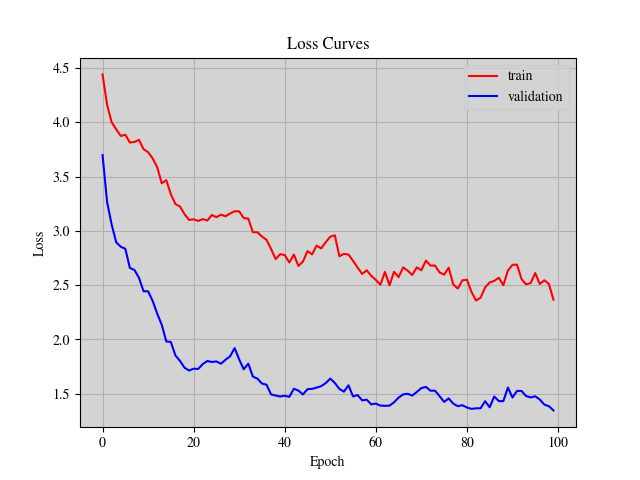

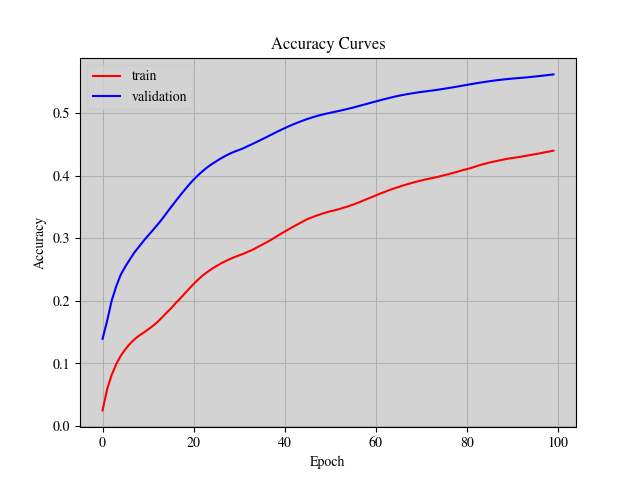

<Figure size 640x480 with 0 Axes>

In [ ]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)
    model = MODEL()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=int(
            EARLY_STOPPING_PATIENCE * EPOCH
        ),
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [ ]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/VisionTransformer_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/VisionTransformer_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/VisionTransformer_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Lo

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_acc_top1       │    0.6492008566856384     │
│       test_acc_top5       │    0.8728880882263184     │
│         test_loss         │    1.3527830839157104     │
└───────────────────────────┴───────────────────────────┘

## **Inference**

Files already downloaded and verified


<Figure size 640x480 with 0 Axes>

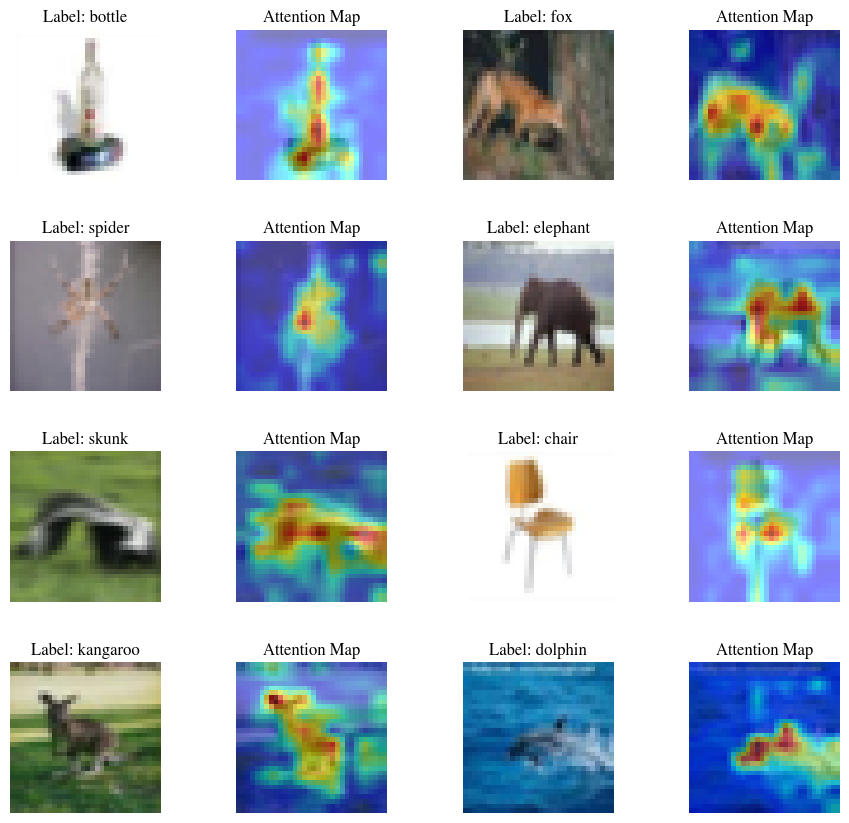

In [ ]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH)

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

class_bin = list()


InferenceDataset = CIFAR100(
    root="experiment/dataset",
    train=False,
    download=True,
)


for index in range(8):
    while True:
        sample_idx = random.randint(0, len(InferenceDataset) - 1)
        image, gt_idx = InferenceDataset[sample_idx]
        gt_class = InferenceDataset.classes[gt_idx]

        prediction = model(
            TEST_TRANSFORM(image).to(
                "cuda" if torch.cuda.is_available else "cpu"
            ).unsqueeze(0)
        )

        prediction.softmax(1)
        predicted_class = InferenceDataset.classes[
            torch.argmax(prediction).data.cpu().numpy()
        ]

        if gt_class == predicted_class and not gt_class in class_bin:
            class_bin.append(gt_class)
            break
        else:
            continue

    title = f"Label: {gt_class}"

    ax = fig.add_subplot(4, 4, (2 * index) + 1)

    image = np.array(image).astype(np.uint8)

    ax.imshow(image)
    ax.set_title(title, fontsize=12)
    ax.set_axis_off()

    attention = list()
    num_attention = len(model.arch.encoder.layers)
    for attn in range(num_attention):
        attention.append(model.arch.encoder.layers[attn].saved_attention)
    attention = torch.cat(attention, 0).sum(0)
    attention_q = attention.sum(0)
    attention_k = attention.sum(1)
    attention = torch.stack([attention_q, attention_k], 0).mean(0, keepdim=True)
    attention = attention.contiguous().view(
        IMAGE_SIZE // PATCH_SIZE, IMAGE_SIZE // PATCH_SIZE, 1
    )
    attention = cv2.resize(
        attention.detach().cpu().numpy(),
        (image.shape[1], image.shape[0]),
        interpolation = cv2.INTER_LINEAR,
    )
    attention = (
        (attention - attention.min()) / (attention.max() - attention.min())
    ) * 255.
    attention = cv2.applyColorMap(attention.astype(np.uint8), cv2.COLORMAP_JET)
    attention = cv2.cvtColor(attention, cv2.COLOR_BGR2RGB)

    image = cv2.addWeighted(attention, 0.5, image, 0.5, 0)

    title = f"Attention Map"

    ax = fig.add_subplot(4, 4, (2 * index) + 2)

    ax.imshow(image)
    ax.set_title(title, fontsize=12)
    ax.set_axis_off()

plt.show()

del InferenceDataset